# <center>**Resolución Trabajo Práctico Número 2**</center>

#### <center>Visión por computadoras I - CEIA, Fiuba</center>

---

**Alumna:** Gambarte, Antonella Nerea

---


In [288]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import math

**Funciones auxiliares**


In [289]:
# Lectura de frames de video
def read_video_frames():
    cap = cv2.VideoCapture('assets/focus_video.mov')
    frames = []
    ok, frame = cap.read()
    count = 0
    while ok:
        frames.append(frame)
        ok, frame = cap.read()
    cap.release()
    return frames

# Conversión a escala de grises
def to_gray(img):
    if img.ndim == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# Para realizar gráficos
def plot_focus_curve(values,smooth=False,max_focus_frames=None,max_focus_point=None, title="Evolución de la métrica de enfoque"):
    plt.figure(figsize=(10,5))
    plt.plot(values, marker='o', color='b', linewidth=1)

    if smooth:
        smooth_values = gaussian_filter1d(values, sigma=2.0)
        plt.plot(smooth_values, linestyle="--", color='orange', linewidth=2, label=f"FM suavizada")

    if max_focus_frames is not None and len(max_focus_frames) > 0:
        plt.axvspan(max_focus_frames[0], max_focus_frames[-1], color="red", alpha=0.3, label="Región de máximo enfoque")

    if max_focus_point is not None:
        plt.axvline(max_focus_point, color='green', linestyle=":", linewidth=2, label="Punto de mayor enfoque")
        plt.scatter(max_focus_point, values[max_focus_point], color='green', s=100, zorder=5)

    plt.xlabel("Frame")
    plt.ylabel("Métrica de enfoque (FM)")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**1. Algoritmo para cálculo de métrica**


In [290]:
def frequency_blur_measure(img_gray):
    I = np.asarray(img_gray, dtype=np.float32)
    F = np.fft.fft2(I) # Paso 1 - FFT 2D
    Fc = np.fft.fftshift(F) # Paso 2 - Shift para centrar el espectro
    AF = np.abs(Fc) # Paso 3 - Magnitud absoluta
    M = np.max(AF) # Paso 4 - Máximo valor del espectro
    thres = M / 1000.0 # Paso 5 - Umbral thres = M/1000 (valor sugerido en el paper)
    TH = np.sum(AF > thres) # Paso 6 - Contar píxeles con valor > thres
    total_pixels = AF.shape[0] * AF.shape[1] # Paso 7 - Total de píxeles (M×N)
    FM = TH / total_pixels # Paso 8 - Cálculo de métrica

    return FM

**Funcioón para detección de área de mayor enfoque**

Para su detección se decidió tomar aquellos frames que tengan un FM por lo menos un 90% del FM máximo.


In [291]:
def maximum_focus_region_detection(fm_values):
    smooth = gaussian_filter1d(fm_values, sigma=2.0)  # suavizado para reducir ruido
    threshold = 0.9 * smooth.max() # Umbral: consideramos frames con FM >= 90% del máximo
    max_focus_frames = np.where(smooth >= threshold)[0]

    # Frame de máximo enfoque
    max_focus_point = int(np.argmax(smooth))

    return max_focus_frames,max_focus_point


**1.1. Medición sobre todo el frame**


**Cálculo de FM para frames del video**


In [292]:
frames = read_video_frames()

fm_values = []
for i, frame in enumerate(frames):
    gray = to_gray(frame)                      
    fm = frequency_blur_measure(gray)          
    fm_values.append(fm)

fm_values = np.array(fm_values)

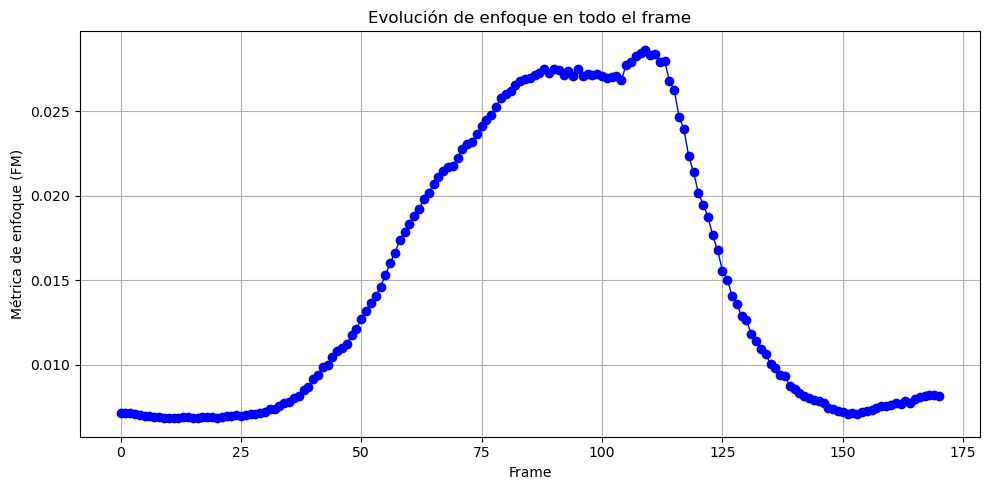

In [293]:
plot_focus_curve(fm_values, title="Evolución de enfoque en todo el frame")

**Detección de área de mayor enfoque**


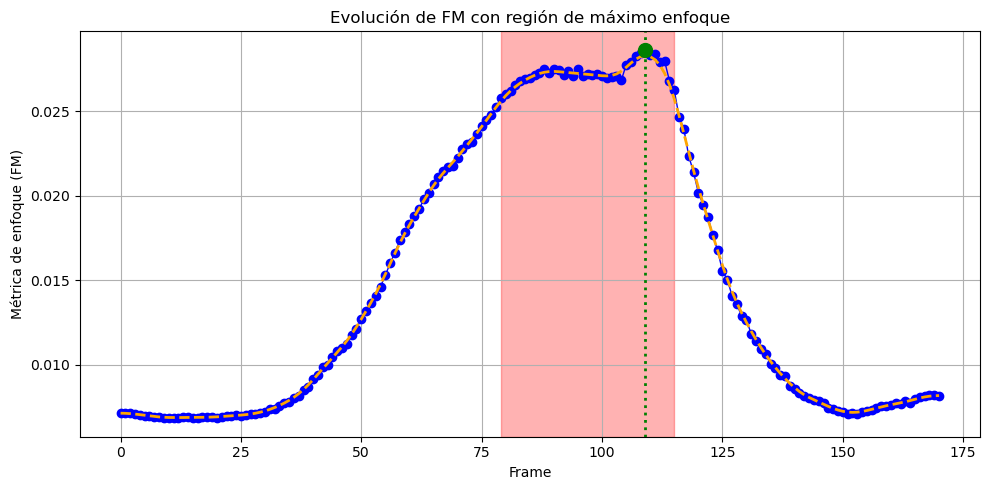

In [294]:
maximum_focus, max_focus_point = maximum_focus_region_detection(fm_values)
plot_focus_curve(
    values=fm_values,
    smooth=True,
    max_focus_frames=maximum_focus,
    max_focus_point=max_focus_point,
    title="Evolución de FM con región de máximo enfoque")


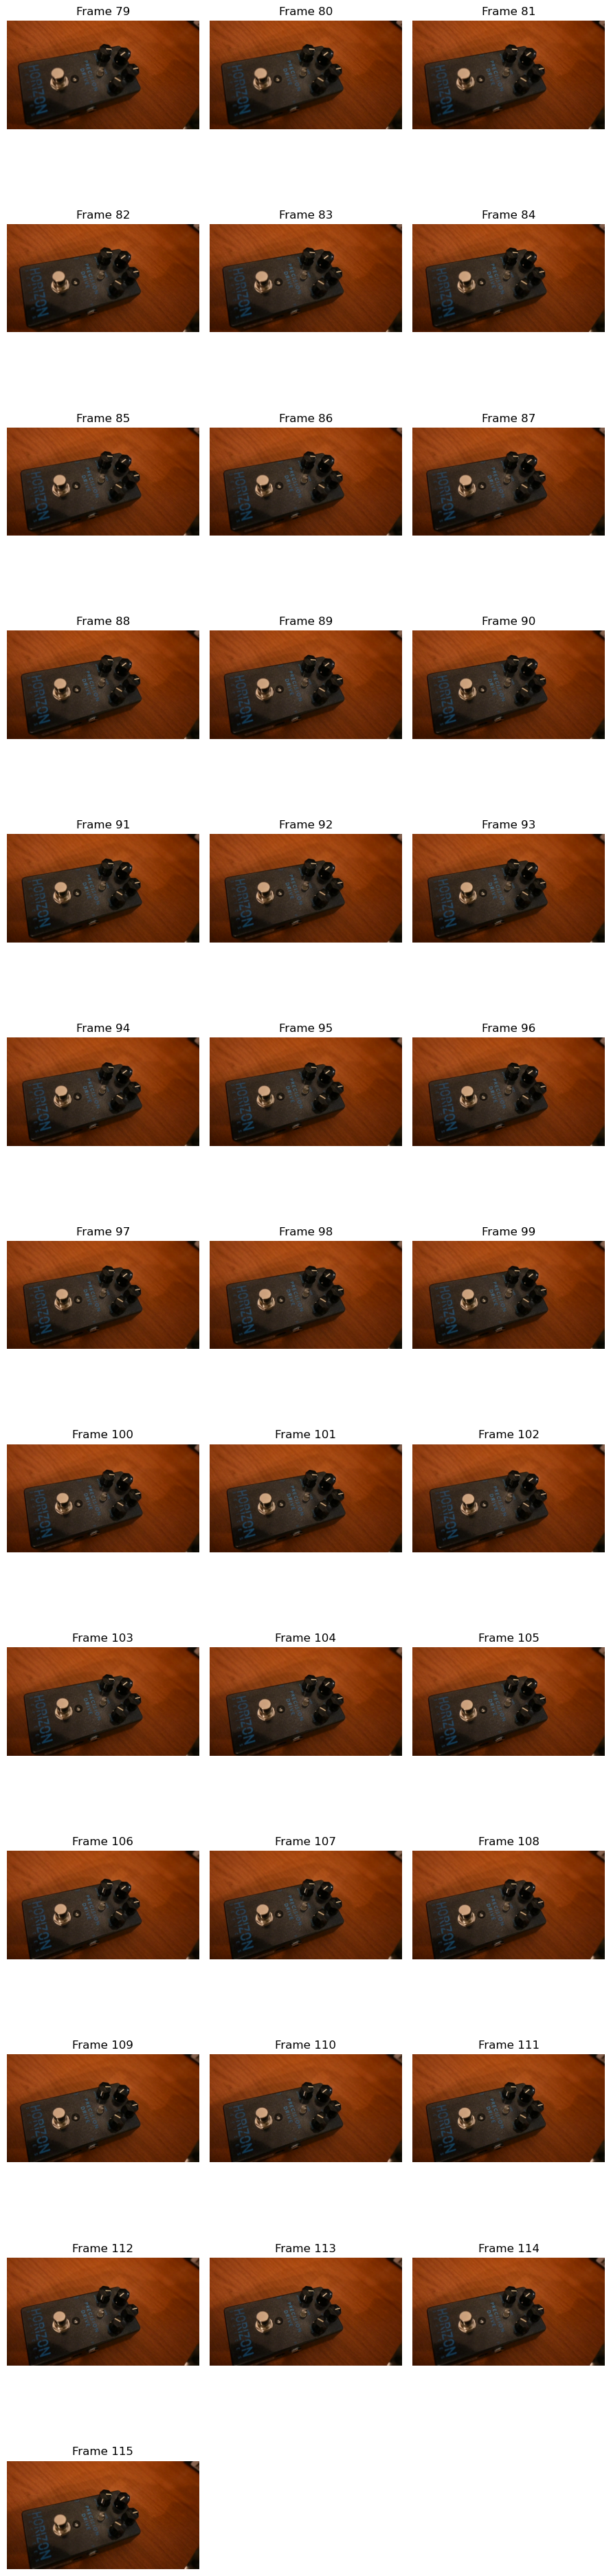

In [295]:
cols = 3  # número de frames por fila
n_frames = len(max_focus_frames)
rows = math.ceil(n_frames / cols)

plt.figure(figsize=(cols*3, rows*3))
for i, idx in enumerate(max_focus_frames):
    frame = frames[idx]
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i+1)
    plt.imshow(frame_rgb)
    plt.title(f"Frame {idx}")
    plt.axis("off")
plt.tight_layout()
plt.show()

**2. Medición sobre una ROI ubicada en el centro del frame. Areade la ROI = 5 o 10% del area total del frame**


In [296]:
def central_roi_coords(h, w, area_fraction):
    total_area = h * w
    target_area = total_area * area_fraction
    aspect = w / h
    roi_h = int(np.sqrt(target_area / aspect))
    roi_w = int(np.round(roi_h * aspect))
    y0 = (h - roi_h) // 2
    x0 = (w - roi_w) // 2
    return (x0, y0, roi_w, roi_h)

In [297]:
# Tomamos un frame para obtener las dimensiones
h, w = to_gray(frames[0]).shape

# ROI central 5%
x0_5, y0_5, w_5, h_5 = central_roi_coords(h, w, 0.05)

# ROI central 10%
x0_10, y0_10, w_10, h_10 = central_roi_coords(h, w, 0.10)

# Función para extraer la ROI y calcular FM
def fm_roi(frame, roi):
    gray = to_gray(frame)
    x0, y0, w_roi, h_roi = roi
    patch = gray[y0:y0+h_roi, x0:x0+w_roi]
    return frequency_blur_measure(patch)


In [298]:
# Serie de FM para ROI 5%
fm_values_5 = [fm_roi(f, (x0_5, y0_5, w_5, h_5)) for f in frames]

# Serie de FM para ROI 10%
fm_values_10 = [fm_roi(f, (x0_10, y0_10, w_10, h_10)) for f in frames]


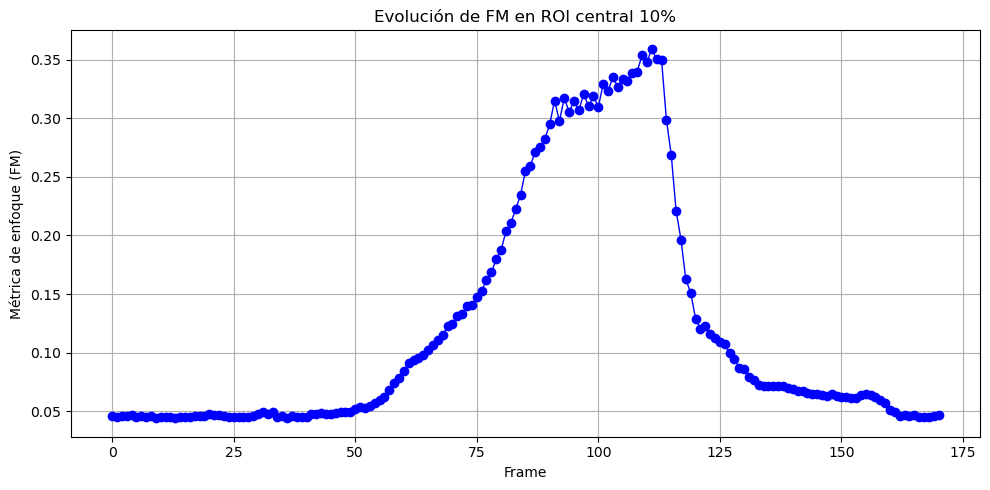

In [299]:
plot_focus_curve(fm_values_10, title="Evolución de FM en ROI central 10%")